# Experiments

For a full description of the experimental setup, see the [documentation](../docs/experimental-setup.md).

In [1]:
# General setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from typing import List

# Uncomment this line to enable interactive plots when running the experiment in Jupyter Notebook
# %matplotlib widget

# Prepare DataFrames to store the results
runtimes = pd.DataFrame(columns=["run_id", "scenario", "solver", "n_proposals", "run_iter", "seed", "start_time", "end_time", "runtime"])
results = pd.DataFrame(columns=["run_id", "utility_id", "adaptation_id", "utility"])

# Prepare a dict to store the adaptations (key: adaptation_id, value: adaptation)
adaptations = {}

# Prepare a dict to store the utility functions (key: utility_id, value: utility function)
utility_functions = {}

# Prepare a dict to store the expected utilities (key: scenario_id, value: expected utility)
expected_utilities = {}

## Overview

The experiments are conducted in the following steps for each scenario:
- Create a sample of utility functions
- For each optimization method:
    - For each seed:
        - Create 10 adaptation proposals
        - Evaluate the adaptation proposals using the utility functions
        - Determine the best adaptation proposal using the utility functions (max utility)
        - Determine the utility of the single (i.e., first/equally weighted) adaptation proposal
- Compare the distributions of maximum utilities for the solvers and number of proposals
- Compare the distributions of runtimes for the solvers and number of proposals

## Scenario 1: LIN+CONV

In this first scenario, we compare the maximum utilities and runtimes for an optimization with a convex Pareto frontier where the utility function can be expressed as a linear combination of the objectives.

In [2]:
import experiments.user
import experiments.problem

# Specify the scenario
SCENARIO_1 = "LIN+CONV"

# Get utility functions
SCENARIO_1_PREFERENCE_CRITERIA = ["neck", "shoulder_exp"]
utility_functions = experiments.user.get_utility_functions_for_different_seeds(SCENARIO_1_PREFERENCE_CRITERIA, n_functions=100, seed=111)

# Get MOO problem
SCENARIO_1_OBJECTIVES = SCENARIO_1_PREFERENCE_CRITERIA
problem_1 = experiments.problem.LayoutProblem(
    objectives=SCENARIO_1_OBJECTIVES
)

Having set up the utility functions and the optimization problem, we can now generate the adaptations for each solver and seed.

In [3]:
import experiments.simulate

runtimes_1, results_1 = experiments.simulate.get_runtimes_and_results_dfs(problem_1, SCENARIO_1, utility_functions, n_runs=10, seed=256)

Now, to create a baseline for the utility of the single adaptation proposal, we create a sample of random adaptation proposals and evaluate them using the utility functions.

In [4]:
import experiments.simulate

# Get baseline for expected utility
expected_utilities[SCENARIO_1] = experiments.simulate.get_expected_utility(SCENARIO_1_PREFERENCE_CRITERIA, list(utility_functions.values()), n_trials=1000, seed=111)

In [5]:
import experiments.visualize

experiments.visualize.get_results_df(runtimes_1, results_1)

,scenario,solver,n_proposals,mean_max_utility,std_max_utility,mean_runtime,std_runtime
0,LIN+CONV,Ours,1,0.889187,0.000433,2.298925,0.179560
1,LIN+CONV,Ours,10,0.932117,0.030087,2.145509,0.038844
2,LIN+CONV,WS,1,0.896064,0.031258,1.636871,0.020185
3,LIN+CONV,WS,10,0.896070,0.031261,15.196095,0.084219


In [6]:
import importlib
importlib.reload(experiments.visualize)

<module 'experiments.visualize' from '/Users/au721459/Developer/auit-pareto-solver/experiments/visualize.py'>

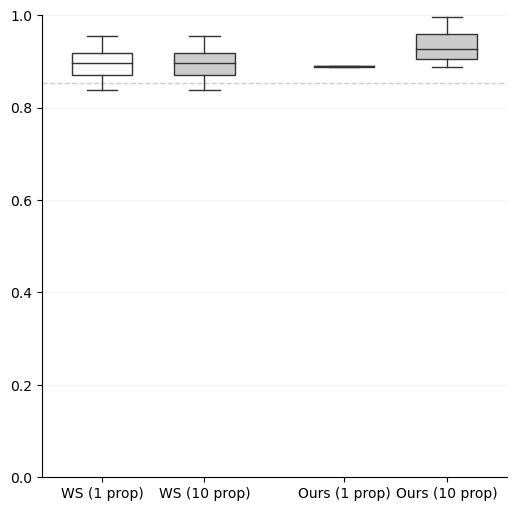

In [7]:
def plot_results(results: pd.DataFrame, runtimes: pd.DataFrame, expected_utility: float, scenario: str):
    """Plot the results for the Pareto solver."""
    # Create a figure
    fig, ax = plt.subplots(figsize=(6, 6))
    # Plot the runtimes
    solver_labels = ["WS (1 prop)", "WS (10 prop)", "Ours (1 prop)", "Ours (10 prop)"]
    solvers = ["WS", "Ours"]
    n_proposals = [1, 10]
    # Get a DataFrame with the max utilities for each condition and configuration
    max_utilities = experiments.visualize.get_max_utilities(runtimes, results)
    fig = experiments.visualize.plot_max_utilities_for_scenario(ax, scenario, solvers, n_proposals, solver_labels, max_utilities, expected_utility)
    return fig

fig_results_1 = plot_results(results_1, runtimes_1, expected_utilities[SCENARIO_1], SCENARIO_1)

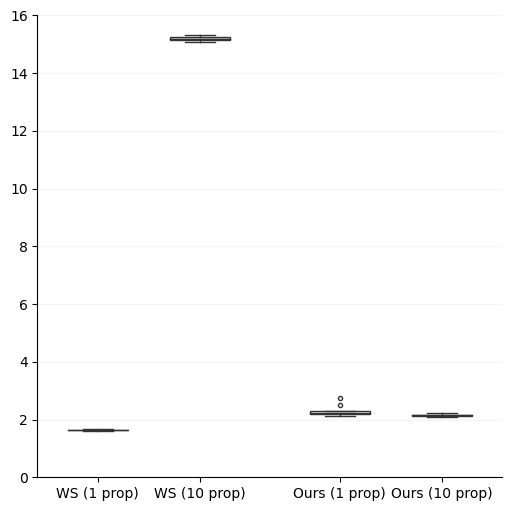

In [8]:
def plot_runtimes(runtimes: pd.DataFrame, scenario: str):
    """Plot the runtimes for the Pareto solver."""
    # Create a figure
    fig, ax = plt.subplots(figsize=(6, 6))
    # Plot the runtimes
    solver_labels = ["WS (1 prop)", "WS (10 prop)", "Ours (1 prop)", "Ours (10 prop)"]
    solvers = ["WS", "Ours"]
    n_proposals = [1, 10]
    fig = experiments.visualize.plot_runtimes_for_scenario(ax, scenario, solvers, n_proposals, solver_labels, runtimes)
    return fig

fig_runtimes_1 = plot_runtimes(runtimes_1, SCENARIO_1)

## Scenario 2: NLIN+NCONV

In this second scenario, we compare the maximum utilities and runtimes for an optimization with a non-convex (concave) Pareto frontier where the utility function cannot be expressed as a linear combination of the objectives.

In [9]:
import experiments.user
import experiments.problem

# Specify the scenario
SCENARIO_2 = "NLIN+NCONV"

# Get utility functions
SCENARIO_2_PREFERENCE_CRITERIA = ["neck", "shoulder_exp", "reach"]
utility_functions = experiments.user.get_utility_functions_for_different_seeds(SCENARIO_2_PREFERENCE_CRITERIA, n_functions=100, seed=111)

# Get MOO problem
SCENARIO_2_OBJECTIVES = ["neck", "shoulder"]
problem_2 = experiments.problem.LayoutProblem(
    objectives=SCENARIO_2_OBJECTIVES
)

Having set up the utility functions and the optimization problem, we can now generate the adaptations for each solver and seed.

In [10]:
import experiments.simulate

runtimes_2, results_2 = experiments.simulate.get_runtimes_and_results_dfs(problem_2, SCENARIO_2, utility_functions, n_runs=10, seed=256)


Now, to create a baseline for the utility of the single adaptation proposal, we create a sample of random adaptation proposals and evaluate them using the utility functions.

In [11]:
# Get baseline for expected utility
expected_utilities[SCENARIO_2] = experiments.simulate.get_expected_utility(SCENARIO_2_PREFERENCE_CRITERIA, list(utility_functions.values()), n_trials=1000, seed=111)
expected_utilities # {'CONV+LIN': 0.682938424996181, 'NCONV+NLIN': -0.4699047227399271}

{'LIN+CONV': 0.8524974871215657, 'NLIN+NCONV': 0.7059483359250157}

In [12]:
experiments.visualize.get_results_df(runtimes_2, results_2)

,scenario,solver,n_proposals,mean_max_utility,std_max_utility,mean_runtime,std_runtime
0,NLIN+NCONV,Ours,1,0.720891,0.091424,2.038633,0.021028
1,NLIN+NCONV,Ours,10,0.785026,0.064626,2.061912,0.027205
2,NLIN+NCONV,WS,1,0.768869,0.086119,1.478216,0.018813
3,NLIN+NCONV,WS,10,0.803586,0.059629,14.779100,0.062044


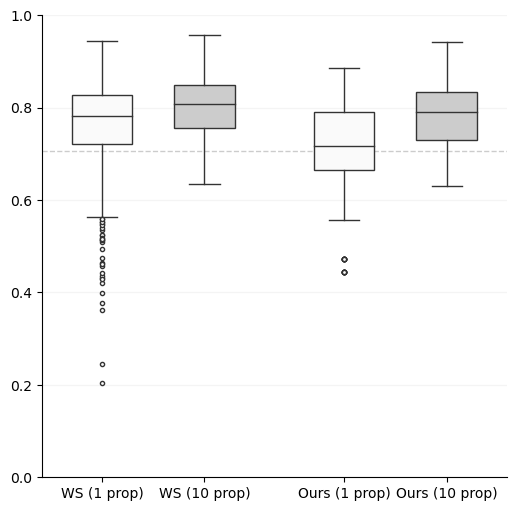

In [13]:
fig_results_2 = plot_results(results_2, runtimes_2, expected_utilities[SCENARIO_2], SCENARIO_2)

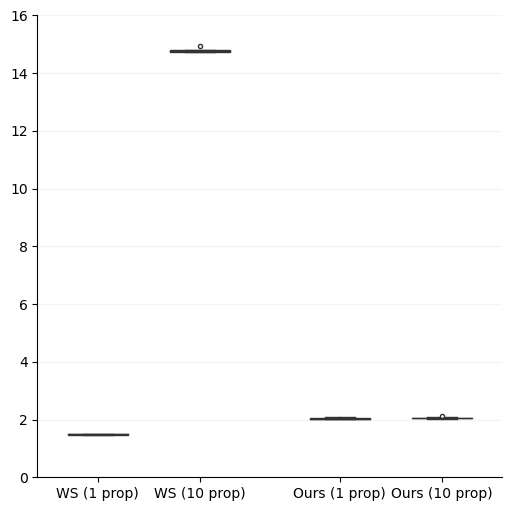

In [14]:
fig_runtimes_2 = plot_runtimes(runtimes_2, SCENARIO_2)

## Scenario 3: NLIN+CONV

In this third scenario, we compare the maximum utilities and runtimes for an optimization with a convex Pareto frontier where the utility function cannot be expressed as a linear combination of the objectives.

In [15]:
import experiments.user
import experiments.problem

# Specify the scenario
SCENARIO_3 = "NLIN+CONV"

# Get utility functions
SCENARIO_3_PREFERENCE_CRITERIA = ["neck", "shoulder_exp", "reach"]
utility_functions = experiments.user.get_utility_functions_for_different_seeds(SCENARIO_3_PREFERENCE_CRITERIA, n_functions=100, seed=111)

# Get MOO problem
SCENARIO_3_OBJECTIVES = ["neck", "shoulder_exp"]
problem_3 = experiments.problem.LayoutProblem(
    objectives=SCENARIO_3_OBJECTIVES
)

In [16]:
import experiments.simulate

runtimes_3, results_3 = experiments.simulate.get_runtimes_and_results_dfs(problem_3, SCENARIO_3, utility_functions, n_runs=10, seed=256)

In [17]:
# Get baseline for expected utility
expected_utilities[SCENARIO_3] = experiments.simulate.get_expected_utility(SCENARIO_3_PREFERENCE_CRITERIA, list(utility_functions.values()), n_trials=1000, seed=111)
expected_utilities # {'CONV+LIN': 0.682938424996181, 'NCONV+NLIN': -0.4699047227399271}

{'LIN+CONV': 0.8524974871215657,
 'NLIN+NCONV': 0.7059483359250157,
 'NLIN+CONV': 0.7059483359250157}

In [18]:
experiments.visualize.get_results_df(runtimes_3, results_3)

,scenario,solver,n_proposals,mean_max_utility,std_max_utility,mean_runtime,std_runtime
0,NLIN+CONV,Ours,1,0.695727,0.106179,2.126265,0.026828
1,NLIN+CONV,Ours,10,0.785015,0.064611,2.113112,0.017797
2,NLIN+CONV,WS,1,0.642711,0.138656,1.526330,0.016684
3,NLIN+CONV,WS,10,0.642716,0.138655,15.657871,0.305322


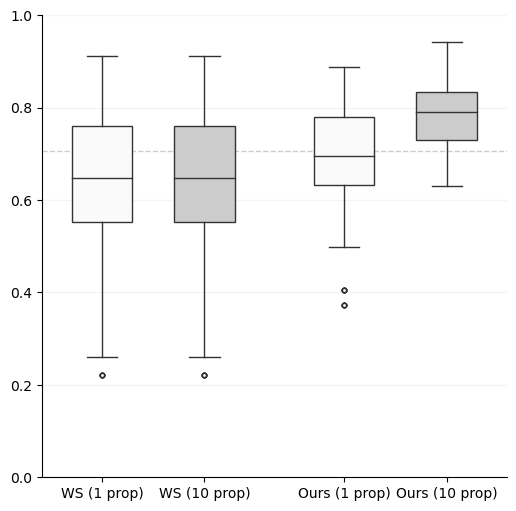

In [19]:
fig_results_3 = plot_results(results_3, runtimes_3, expected_utilities[SCENARIO_3], SCENARIO_3)

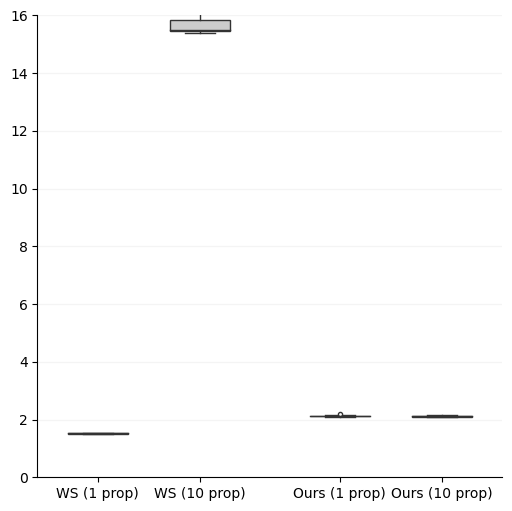

In [20]:
fig_runtimes_3 = plot_runtimes(runtimes_3, SCENARIO_3)

## Scenario 4: LIN+NCONV

In this fourth scenario, we compare the maximum utilities and runtimes for an optimization with a non-convex (concave) Pareto frontier where the utility function can be expressed as a linear combination of the objectives.

In [21]:
import experiments.user
import experiments.problem

# Specify the scenario
SCENARIO_4 = "LIN+NCONV"

# Get utility functions
SCENARIO_4_PREFERENCE_CRITERIA = ["neck", "shoulder_exp"]
utility_functions = experiments.user.get_utility_functions_for_different_seeds(SCENARIO_4_PREFERENCE_CRITERIA, n_functions=100, seed=111)

# Get MOO problem
SCENARIO_4_OBJECTIVES = ["neck", "shoulder"]
problem_4 = experiments.problem.LayoutProblem(
    objectives=SCENARIO_4_OBJECTIVES
)

In [22]:
import experiments.simulate

runtimes_4, results_4 = experiments.simulate.get_runtimes_and_results_dfs(problem_4, SCENARIO_4, utility_functions, n_runs=10, seed=256)

In [23]:
# Get baseline for expected utility
expected_utilities[SCENARIO_4] = experiments.simulate.get_expected_utility(SCENARIO_4_PREFERENCE_CRITERIA, list(utility_functions.values()), n_trials=1000, seed=111)
expected_utilities # {'CONV+LIN': 0.682938424996181, 'NCONV+NLIN': -0.4699047227399271}

{'LIN+CONV': 0.8524974871215657,
 'NLIN+NCONV': 0.7059483359250157,
 'NLIN+CONV': 0.7059483359250157,
 'LIN+NCONV': 0.8524974871215657}

In [24]:
experiments.visualize.get_results_df(runtimes_4, results_4)

,scenario,solver,n_proposals,mean_max_utility,std_max_utility,mean_runtime,std_runtime
0,LIN+NCONV,Ours,1,0.886339,0.009049,2.062737,0.029929
1,LIN+NCONV,Ours,10,0.932305,0.030244,2.054493,0.022759
2,LIN+NCONV,WS,1,0.872140,0.058111,1.538864,0.043394
3,LIN+NCONV,WS,10,0.907196,0.038916,14.952541,0.049462


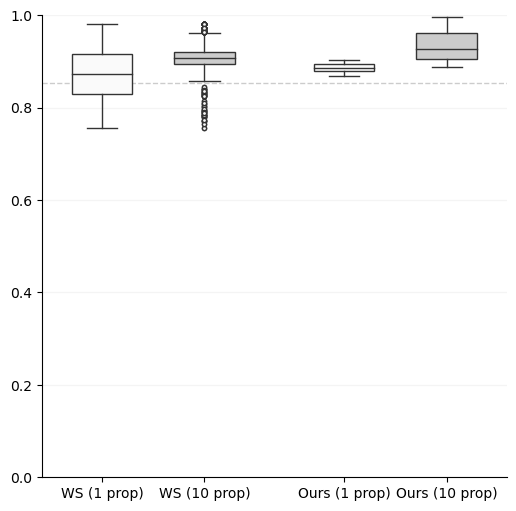

In [25]:
fig_results_4 = plot_results(results_4, runtimes_4, expected_utilities[SCENARIO_4], SCENARIO_4)

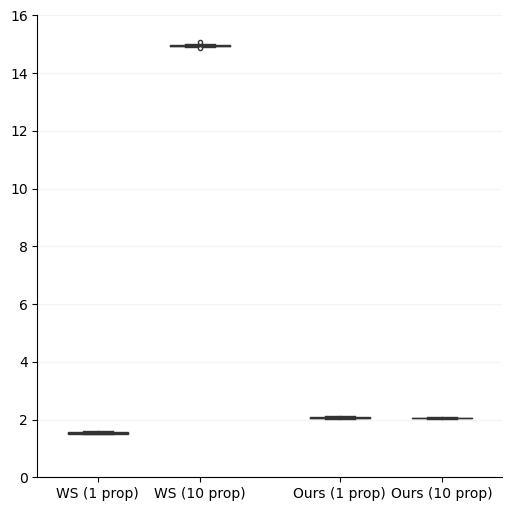

In [26]:
fig_runtimes_4 = plot_runtimes(runtimes_4, SCENARIO_4)

In [27]:
# Save expected utilities
import json
with open("data/expected_utilities.json", "w") as f:
    json.dump(expected_utilities, f)

## Results

Finally, let us view and plot the results of the experiments.

In [126]:
import json

# Read in the results from the experiments
runtimes = pd.read_csv("data/runtimes.csv")
results = pd.read_csv("data/results.csv")
expected_utilities = json.load(open("data/expected_utilities.json"))

In [29]:
runtimes = pd.concat([runtimes_1, runtimes_2, runtimes_3, runtimes_4])
results = pd.concat([results_1, results_2, results_3, results_4])
# Store the results
runtimes.to_csv("data/runtimes.csv", index=False)
results.to_csv("data/results.csv", index=False)

In [127]:
runtimes.head()

,run_id,scenario,solver,n_proposals,run_iter,seed,start_time,end_time,runtime
0,99341da3-acf9-40bb-a28f-2aef43562af7,LIN+CONV,WS,1,1,113,2023-04-01 14:52:28.204382,2023-04-01 14:52:29.862272,1.657890
1,3027a335-cc55-4a03-8b66-e5b7766a4a3e,LIN+CONV,WS,1,2,183,2023-04-01 14:52:29.866867,2023-04-01 14:52:31.498185,1.631318
2,303c540e-e49a-4f82-91af-bf6103905933,LIN+CONV,WS,1,3,172,2023-04-01 14:52:31.502923,2023-04-01 14:52:33.106265,1.603342
3,6078f8b8-22ea-4ad8-aacc-5738e4b95699,LIN+CONV,WS,1,4,253,2023-04-01 14:52:33.110888,2023-04-01 14:52:34.750615,1.639727
4,5a76b570-b5cf-4e1e-90e0-9fd50e9764a8,LIN+CONV,WS,1,5,33,2023-04-01 14:52:34.755453,2023-04-01 14:52:36.405867,1.650414


In [128]:
results.head()

,run_id,utility_id,adaptation_id,utility
0,99341da3-acf9-40bb-a28f-2aef43562af7,e7b4e788-440b-437d-a385-6ac27a9d4b0d,01a0f334-3f13-4b02-a014-5208bf947315,0.890018
1,99341da3-acf9-40bb-a28f-2aef43562af7,6d8f0747-6854-4c1c-8d52-5726c022cffc,01a0f334-3f13-4b02-a014-5208bf947315,0.884713
2,99341da3-acf9-40bb-a28f-2aef43562af7,44e31957-ad4c-432d-a8c9-d939a0792b91,01a0f334-3f13-4b02-a014-5208bf947315,0.941557
3,99341da3-acf9-40bb-a28f-2aef43562af7,f09daded-0d3b-481e-97a6-e614686af61d,01a0f334-3f13-4b02-a014-5208bf947315,0.886893
4,99341da3-acf9-40bb-a28f-2aef43562af7,521092c8-a37d-4a45-80d6-6b4c96fdb36f,01a0f334-3f13-4b02-a014-5208bf947315,0.900313


In [129]:
import experiments.visualize

# SEED = 42
# random_runtimes = experiments.visualize.create_random_runtimes(seed=SEED)
# random_utilities = experiments.visualize.create_random_utilities(seed=SEED)
# expected_utilities = {"CONV+LIN": 0.5, "NCONV+NLIN": 0.5}
experiments.visualize.get_results_df(runtimes, results)

,scenario,solver,n_proposals,mean_max_utility,std_max_utility,mean_runtime,std_runtime
0,LIN+CONV,Ours,1,0.889187,0.000433,2.298925,0.179560
1,LIN+CONV,Ours,10,0.932117,0.030087,2.145509,0.038844
2,LIN+CONV,WS,1,0.896064,0.031258,1.636871,0.020185
3,LIN+CONV,WS,10,0.896070,0.031261,15.196095,0.084219
4,LIN+NCONV,Ours,1,0.886339,0.009049,2.062737,0.029929
5,LIN+NCONV,Ours,10,0.932305,0.030244,2.054493,0.022759
6,LIN+NCONV,WS,1,0.872140,0.058111,1.538864,0.043394
7,LIN+NCONV,WS,10,0.907196,0.038916,14.952541,0.049462
8,NLIN+CONV,Ours,1,0.695727,0.106179,2.126265,0.026828
9,NLIN+CONV,Ours,10,0.785015,0.064611,2.113112,0.017797


In [130]:
def get_results_latex(runtimes, results):
    df = experiments.visualize.get_results_df(runtimes, results)
    table = pd.pivot_table(df, values=['mean_max_utility', 'std_max_utility', 'mean_runtime', 'std_runtime'],
                       index=['solver', 'n_proposals'],
                       columns=['scenario'])

    result = table.applymap(lambda x: f'{x:.2f}')
    result.index.names = ['Optim', 'No. Props']
    result.columns.names = ['Scenario', '']

    return result

get_results_latex(runtimes, results)

Scenario        mean_max_utility                                mean_runtime  \
                        LIN+CONV LIN+NCONV NLIN+CONV NLIN+NCONV     LIN+CONV   
Optim No. Props                                                                
Ours  1                     0.89      0.89      0.70       0.72         2.30   
      10                    0.93      0.93      0.79       0.79         2.15   
WS    1                     0.90      0.87      0.64       0.77         1.64   
      10                    0.90      0.91      0.64       0.80        15.20   

Scenario                                       std_max_utility            \
                LIN+NCONV NLIN+CONV NLIN+NCONV        LIN+CONV LIN+NCONV   
Optim No. Props                                                            
Ours  1              2.06      2.13       2.04            0.00      0.01   
      10             2.05      2.11       2.06            0.03      0.03   
WS    1              1.54      1.53       1.48            0.03      0.06   
      10            14.95     15.66      14.78            0.03      0.04   

Scenario                             std_runtime                      \
                NLIN+CONV NLIN+NCONV    LIN+CONV LIN+NCONV NLIN+CONV   
Optim No. Props                                                        
Ours  1              0.11       0.09        0.18      0.03      0.03   
      10             0.06       0.06        0.04      0.02      0.02   
WS    1              0.14       0.09        0.02      0.04      0.02   
      10             0.14       0.06        0.08      0.05      0.31   

Scenario                    
                NLIN+NCONV  
Optim No. Props             
Ours  1               0.02  
      10              0.03  
WS    1               0.02  
      10              0.06

In [151]:
import importlib
importlib.reload(experiments.visualize)

<module 'experiments.visualize' from '/Users/au721459/Developer/auit-pareto-solver/experiments/visualize.py'>

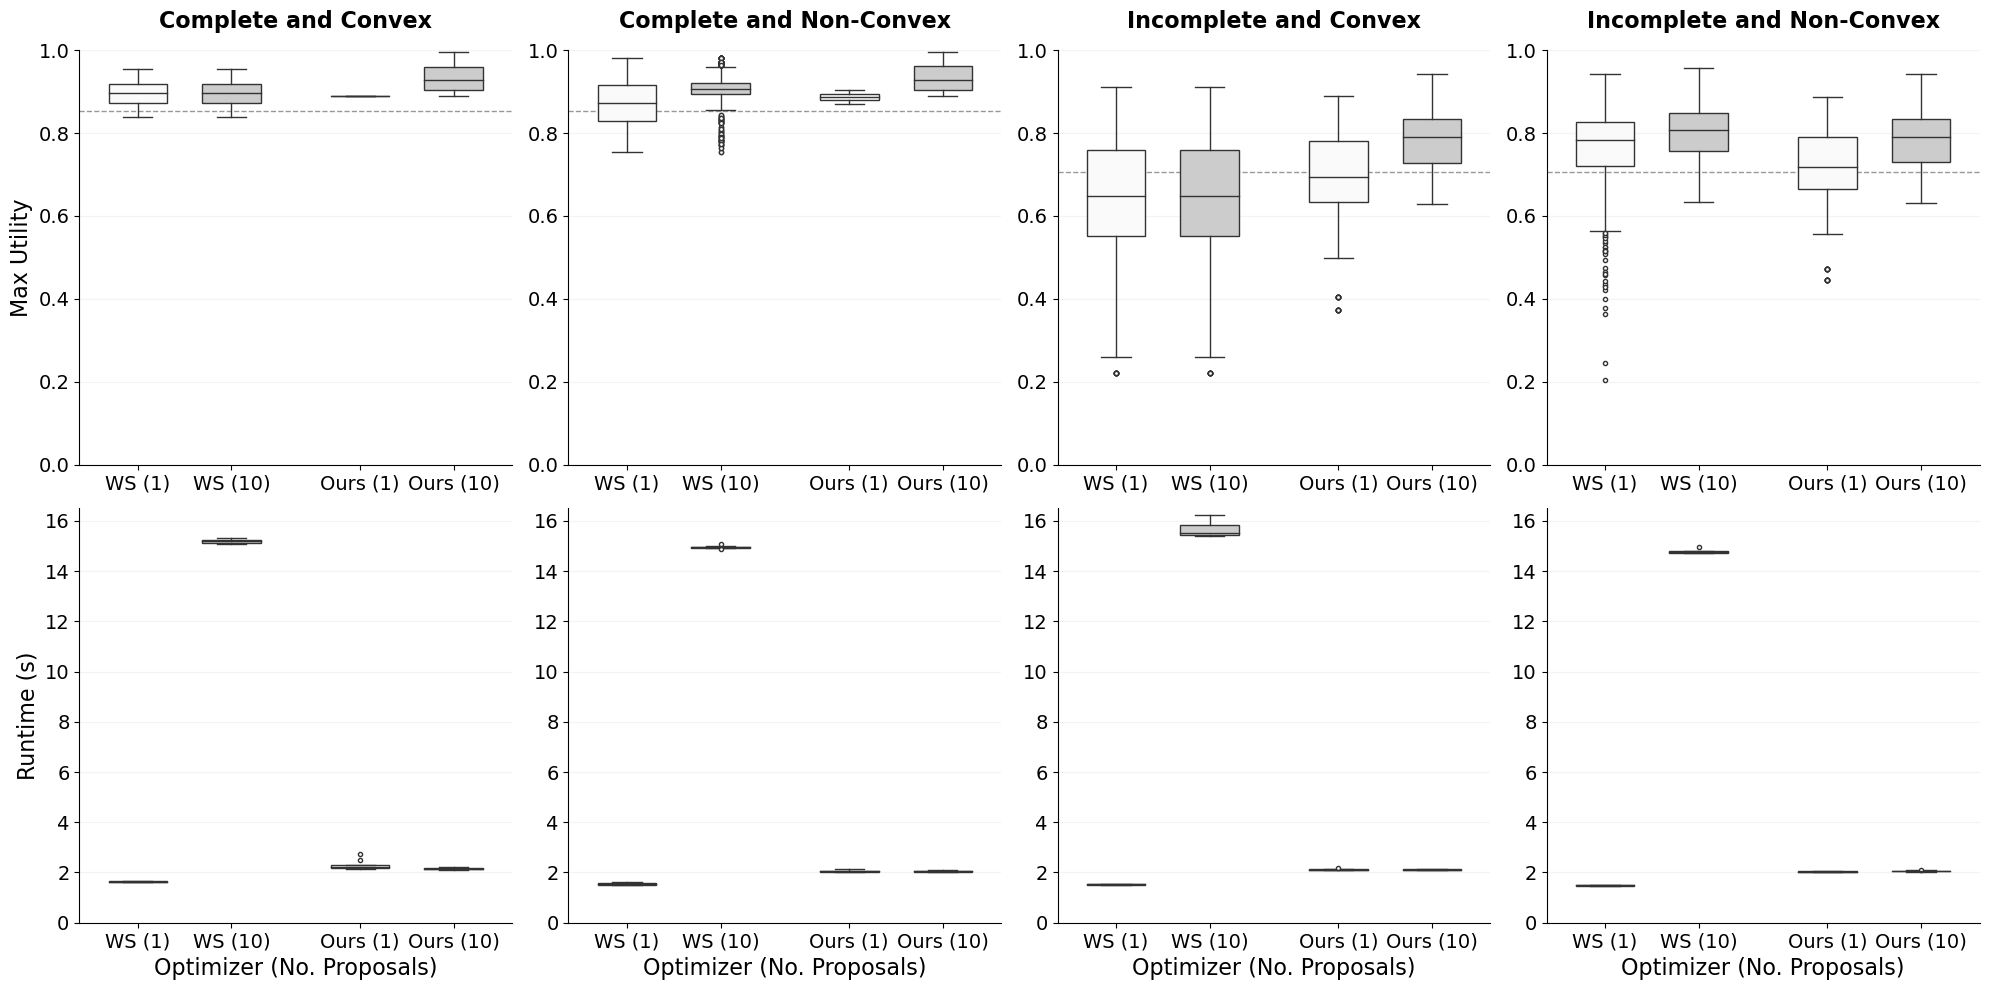

In [152]:
# fig_runtimes = experiments.visualize.plot_runtimes(random_runtimes)
# fig_max_utilities = experiments.visualize.plot_max_utilities(random_runtimes, random_utilities, expected_utilities)
fig_results = experiments.visualize.plot_results(runtimes, results, expected_utilities, scenarios=["LIN+CONV", "LIN+NCONV", "NLIN+CONV", "NLIN+NCONV"])
fig_results

In [153]:
# Save the figure
fig_results.savefig("figures/results.pdf", bbox_inches="tight")
fig_results.savefig("figures/results.png", bbox_inches="tight", dpi=300)

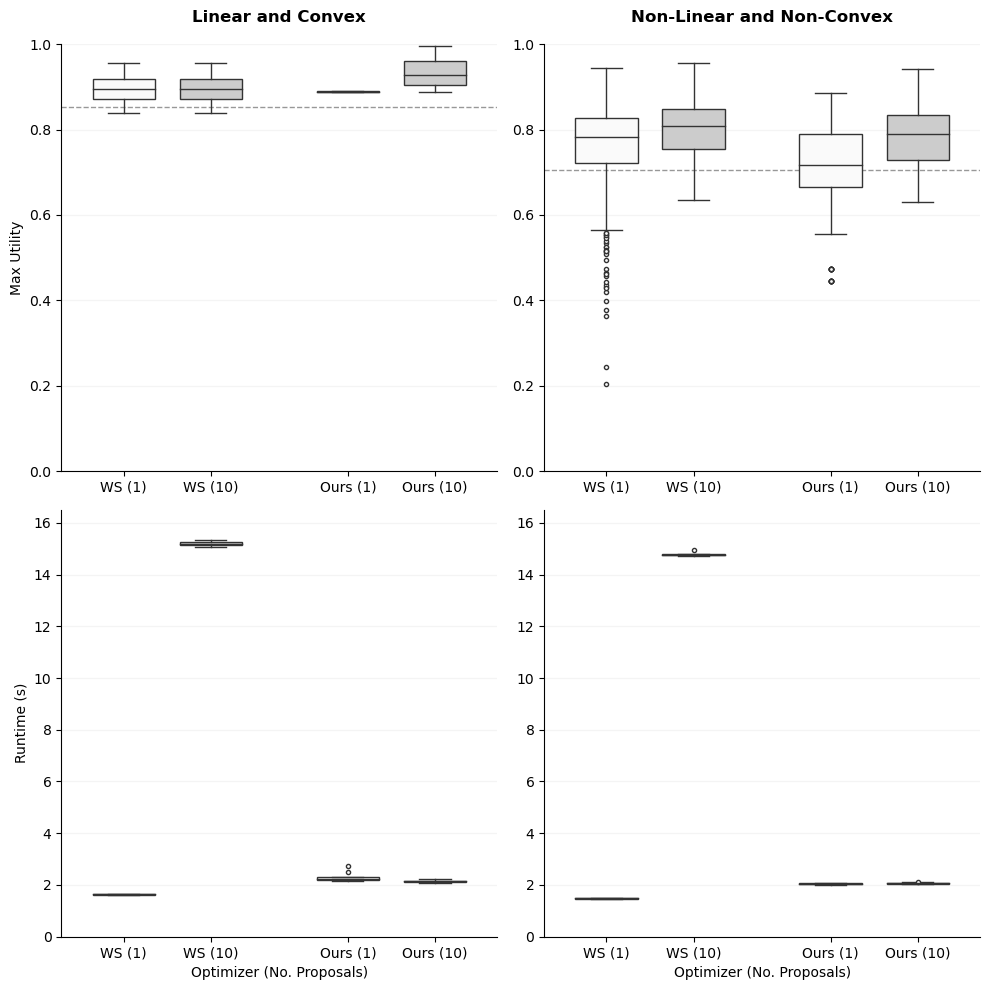

In [125]:
fig_results = experiments.visualize.plot_results(runtimes, results, expected_utilities, scenarios=["LIN+CONV", "NLIN+NCONV"])
fig_results

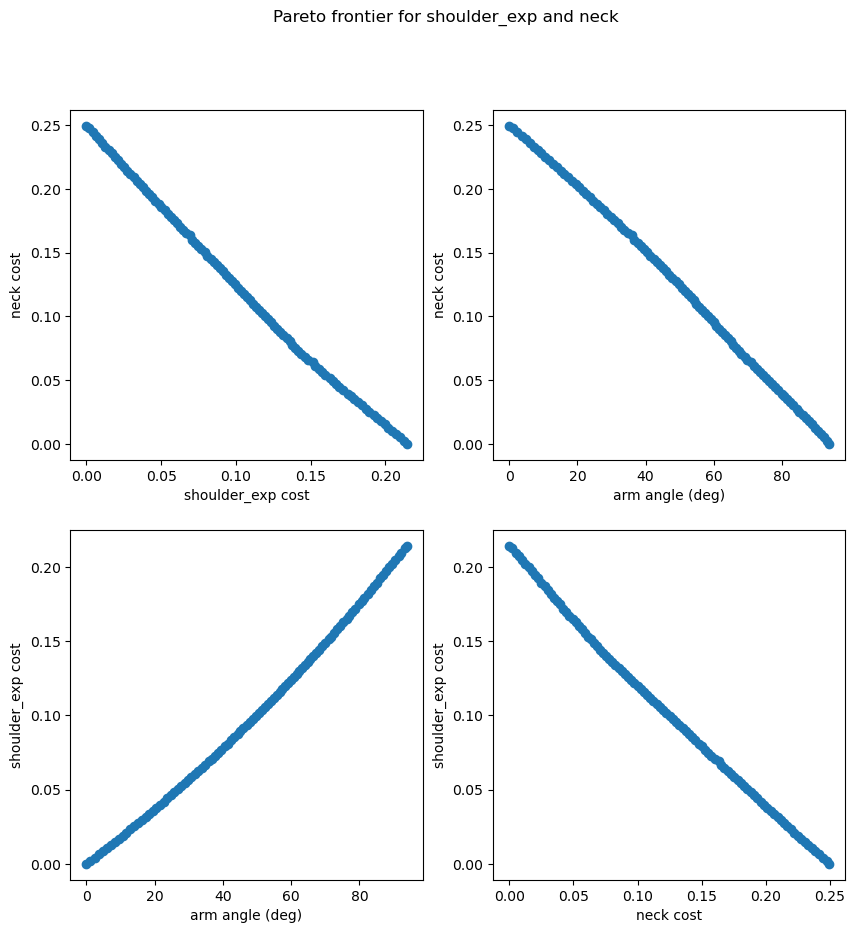

In [79]:
import AUIT
import experiments.config

# Verify convex Pareto frontier shape for scenario 1
def plot_pareto_fontier(objective_x="neck", objective_y="shoulder_exp"):
    problem = experiments.problem.LayoutProblem([objective_x, objective_y])
    solver = experiments.pareto_solver.ParetoSolver(problem=problem, pop=100, n_gen=100, seed=42)
    pareto_optimal_adaptations = solver.get_adaptations()
    get_utility_x = experiments.user.get_utility_function([objective_x])
    get_utility_y = experiments.user.get_utility_function([objective_y])
    x_costs = [1 - get_utility_x(adaptation) for adaptation in pareto_optimal_adaptations]
    y_costs = [1 - get_utility_y(adaptation) for adaptation in pareto_optimal_adaptations]
    # Create a new figure with four subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle(f"Pareto frontier for {objective_x} and {objective_y}")
    # Plot Pareto frontier
    axes[0, 0].scatter(x_costs, y_costs)
    axes[0, 0].set_xlabel(f"{objective_x} cost")
    axes[0, 0].set_ylabel(f"{objective_y} cost")
    # Plot x cost dependent on y-position
    axes[1, 0].scatter([AUIT.get_arm_angle_deg(experiments.config.SHOULDER_JOINT_POSITION, adaptation.items[0]) for adaptation in pareto_optimal_adaptations], x_costs)
    axes[1, 0].set_xlabel("arm angle (deg)")
    axes[1, 0].set_ylabel(f"{objective_x} cost")
    # Plot y cost dependent on y-position
    axes[0, 1].scatter([AUIT.get_arm_angle_deg(experiments.config.SHOULDER_JOINT_POSITION, adaptation.items[0]) for adaptation in pareto_optimal_adaptations], y_costs)
    axes[0, 1].set_xlabel("arm angle (deg)")
    axes[0, 1].set_ylabel(f"{objective_y} cost")
    # Plot Pareto frontier
    axes[1, 1].scatter(y_costs, x_costs)
    axes[1, 1].set_xlabel(f"{objective_y} cost")
    axes[1, 1].set_ylabel(f"{objective_x} cost")
    plt.show()

plot_pareto_fontier("shoulder_exp", "neck")
    